### Exponential Moving Average Strategy

<font color='orange'>
    Exponential Moving Average (EMA) is similar to Simple Moving Average (SMA), measuring trend direction over a period of time. However, whereas SMA simply calculates an average of price data, EMA applies more weight to data that is more current. Because of its unique calculation, EMA will follow prices more closely than a corresponding SMA.
    $$
    E M A=\operatorname{Price}(t) \times k+E M A(y) \times(1-k)
    $$
    where:
    $$
    \begin{aligned}
    t&:\text { today } \\
    y&:\text { yesterday } \\
    N&:\text { number of days in EMA } \\
    k&:\text { weighted multiplier } \\
    &=2 \div(N+1)
    \end{aligned}
    $$
</font>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cufflinks as cf
from scipy.optimize import brute
from datetime import datetime
from collections import namedtuple
import math
from numbers import Real
import jdc
plt.style.use('seaborn')

/var/folders/6b/zsc6z0x51ls8w8wy4m79d0y80000gn/T/ipykernel_29880/2261596742.py:11: MatplotlibDeprecationWarning:

The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.



> #### Implementation:

In [2]:
class EMA:
    '''
    Description: 
        Class for the vectorized backtesting of EMA-based trading strategies.

    Properties:
    ===========
    symbol: str
        ticker symbol
    ema_s: int
        time window in days for shorter EMA
    ema_l: int
        time window in days for longer EMA
    start_date: str or datetime
        start date for data retrieval
    end_date: str or datetime
        end date for data retrieval
    tc: Real
        proportional transaction costs per trade

    Methods:
    ========
    load_data:
        retrieve and prepare data given a file path
    prepare_data:
        prepare data
    run_strategy:
        run the backtest for the EMA strategy
    run_with_updated_params:
        update EMA parameters and rerun EMA strategy
    optimize_params:
        implement a brute force optimization to search for optimal EMA parameters
    plot_result:
        plot the performance of the EMA strategy compared to buy-and-hold strategy
    '''
    def __init__(self, symbol, ema_s, ema_l, start_date, end_date, tc):
        self._symbol = symbol
        self._ema_s = ema_s
        self._ema_l = ema_l
        self._start_date = start_date
        self._end_date = end_date
        self._tc = tc
        self.data = None
        self.path = None
        self.result = None
        self.perf = None

    def __repr__(self):
        return f'EMABackTester(symbol: {self.symbol}, ema_short: {self.ema_s}, ema_long: {self.ema_l}, start_date: {self.start_date}, end_date: {self.end_date})'
    
    # Symbol
    @property
    def symbol(self):
        return self._symbol
    @symbol.setter
    def symbol(self, symbol):
        if isinstance(symbol, str):
            self._symbol = symbol
            if self.data is not None:
                self.prepare_data()
            if self.result is not None:
                self.run_strategy()
        else:
            raise ValueError('Symbol must be a string.')

    # Ema_short
    @property
    def ema_s(self):
        return self._ema_s
    @ema_s.setter
    def ema_s(self, ema_s):
        if isinstance(ema_s, int):
            self._ema_s = ema_s
            if self.data is not None:
                self.prepare_data()
            if self.result is not None:
                self.run_strategy()
        else:
            raise ValueError('Ema_short must be an integer.')

    # Ema_long
    @property
    def ema_l(self):
        return self._ema_l
    @ema_l.setter
    def ema_l(self, ema_l):
        if isinstance(ema_l, int):
            self._ema_l = ema_l
            if self.data is not None:
                self.prepare_data()
            if self.result is not None:
                self.run_strategy()
        else:
            raise ValueError('Ema_long must be an integer.')

    # Start_date
    @property
    def start_date(self):
        return self._start_date
    @start_date.setter
    def start_date(self, start_date):
        if isinstance(start_date, str):
            self._start_date = start_date 
        elif isinstance(start_date, datetime):
            self._start_date = start_date.strftime('%Y-%m-%d')
        else:
            raise ValueError('Start_date must be a string or a datetime object.')
            
        if self.data is not None:
            self.prepare_data()
        if self.result is not None:
            self.run_strategy()

    # End_date
    @property
    def end_date(self):
        return self._end_date
    @end_date.setter
    def end_date(self, end_date):
        if isinstance(end_date, str):
            self._end_date = end_date 
        elif isinstance(end_date, datetime):
            self._end_date = end_date.strftime('%Y-%m-%d')
        else:
            raise ValueError('End_date must be a string or a datetime object.')
            
        if self.data is not None:
            self.prepare_data()
        if self.result is not None:
            self.run_strategy()

    @property
    def tc(self):
        return self._tc
    @tc.setter
    def tc(self, tc):
        if isinstance(tc, Real):
            self._tc = tc
            if self.result is not None:
                self.run_strategy()
        else:
            raise ValueError('Trading_cost must be a real number.')

In [3]:
%%add_to EMA
def load_data(self, path):
    '''
    Retrieve and prepare the data given a file path.
    '''
    if isinstance(path, str):
        self.path = path
    else:
        raise ValueError('File path of data must be a string.')
    self.prepare_data()

In [4]:
%%add_to EMA
def prepare_data(self):
    '''
    Prepare data.
    '''
    # Load data
    self.data = pd.read_csv(self.path, parse_dates=['Date'], index_col='Date')
    # Filter data for given symbol
    self.data = self.data[self.symbol].to_frame().dropna()
    # Filter data for given period
    self.data = self.data.loc[self.start_date : self.end_date].copy()
    self.data.rename(columns={self.symbol: 'Price'}, inplace=True)
    
    # ema_short
    self.data['EMA_S'] = self.data['Price'].ewm(span=self.ema_s, min_periods=self.ema_s).mean()
    # ema_long
    self.data['EMA_L'] = self.data['Price'].ewm(span=self.ema_l, min_periods=self.ema_l).mean()
    # If ema_s > ema_l, hold long position and otherwise short
    self.data['Position'] = np.where(self.data['EMA_S'] > self.data['EMA_L'], 1, -1)
    
    # Return of buy-and-hold strategy
    return_buy_and_hold = self.data['Price'] / self.data['Price'].shift(1)
    # Return (log) of buy-and-hold strategy
    self.data['Return_Buy_Hold(log)'] = np.log(return_buy_and_hold)
    # Cumulative return of buy-and-hold strategy
    self.data['Return_Buy_Hold(cum)'] = self.data['Return_Buy_Hold(log)'].cumsum().apply(np.exp)

In [5]:
%%add_to EMA
def run_strategy(self):
    '''
    Backtest the EMA strategy.
    '''
    data = self.data.copy().dropna()
    # Number of trades
    data['Trades'] = data['Position'].diff().fillna(0).abs()
    
    # Return of ema strategy (position of previous day * return of current day)
    data['Return_EMA(log)'] = data['Position'].shift(1) * data['Return_Buy_Hold(log)']
    data.dropna(inplace=True)
    # Return of ema strategy (excluding trading cost)
    data['Return_EMA_Net(log)'] = data['Return_EMA(log)'] - data['Trades'] * self.tc
    
    # Cumulative return of ema strategy
    data['Return_EMA(cum)'] = data['Return_EMA(log)'].cumsum().apply(np.exp)
    # Cumulative return of ema strategy (excluding trading cost)
    data['Return_EMA_Net(cum)'] = data['Return_EMA_Net(log)'].cumsum().apply(np.exp)
    self.result = data

    abs_perf = self.result['Return_EMA(cum)'].iloc[-1]
    out_perf = abs_perf - data['Return_Buy_Hold(cum)'].iloc[-1]

    self.perf = namedtuple('ema_performance', ['ema_abs_performance', 'ema_out_performance'])
    self.perf.ema_abs_performance = round(abs_perf, 6)
    self.perf.ema_out_performance = round(out_perf, 6)
    return self.perf.ema_abs_performance

In [6]:
%%add_to EMA
def run_with_updated_params(self, ema):
    '''
    Update EMA parameters and rerun EMA strategy.

    Parameters:
    ===========
    ema: tuple
        ema parameter tuple
    '''
    self.ema_s = int(ema[0])
    self.ema_l = int(ema[1])
    return -self.run_strategy()

In [7]:
%%add_to EMA
def optimize_params(self, ema_s_range, ema_l_range):
    '''
    Find optimal ema_short and ema_long combination in terms of best possible EMA return.
    
    Parameters:
    ===========
    ema_s_range, ema_l_range: tuple
        ema ranges tuples      
    '''
    opt = brute(self.run_with_updated_params, ranges=(ema_s_range, ema_l_range), finish=None)
    return opt

In [8]:
%%add_to EMA
def plot_result(self):
    '''
    Plots the cumulative performance of the EMA strategy comparing to buy-and-hold.
    '''
    if self.result is None:
        print('No result for display, please run the strategy')
    else:
        title = f'{self.symbol} | EMA_S = {self.ema_s} | EMA_L = {self.ema_l} | TC = {self.tc}'
        self.result[['Return_Buy_Hold(cum)', 'Return_EMA(cum)', 'Return_EMA_Net(cum)']].plot(title=title, figsize=(12, 8))        

> #### Example:

In [9]:
PATH = './data/forex_pairs.csv'

EMA_SHORT = 50
EMA_LONG = 200
EMA_S_RANGE = (25, 75, 1)
EMA_L_RANGE = (100, 200, 1)

SYMBOL = 'EURUSD=X'
START_DATE = '2004-01-01'
END_DATE = '2020-06-30'
TRADING_COST = 0.00007

In [10]:
ema = EMA(symbol=SYMBOL, 
          ema_s=EMA_SHORT, 
          ema_l=EMA_LONG,
          start_date=START_DATE,
          end_date=END_DATE,
          tc=TRADING_COST)
ema

EMABackTester(symbol: EURUSD=X, ema_short: 50, ema_long: 200, start_date: 2004-01-01, end_date: 2020-06-30)

In [11]:
ema.load_data(path = PATH)
ema.data.head()

,Price,EMA_S,EMA_L,Position,Return_Buy_Hold(log),Return_Buy_Hold(cum)
Date,,,,,,
2004-01-01,1.258194,NaN,NaN,-1,NaN,NaN
2004-01-02,1.258194,NaN,NaN,-1,0.000000,1.000000
2004-01-05,1.268698,NaN,NaN,-1,0.008313,1.008348
2004-01-06,1.272103,NaN,NaN,-1,0.002681,1.011055
2004-01-07,1.264095,NaN,NaN,-1,-0.006315,1.004690


In [12]:
ema.run_strategy()
ema.result.head()

,Price,EMA_S,EMA_L,Position,Return_Buy_Hold(log),Return_Buy_Hold(cum),Trades,Return_EMA(log),Return_EMA_Net(log),Return_EMA(cum),Return_EMA_Net(cum)
Date,,,,,,,,,,,
2004-10-07,1.229906,1.224089,1.222309,1,0.001475,0.977517,0.0,0.001475,0.001475,1.001476,1.001476
2004-10-08,1.241003,1.224753,1.222524,1,0.008982,0.986337,0.0,0.008982,0.008982,1.010511,1.010511
2004-10-11,1.238405,1.225288,1.222706,1,-0.002095,0.984272,0.0,-0.002095,-0.002095,1.008396,1.008396
2004-10-12,1.232104,1.225556,1.222813,1,-0.005102,0.979264,0.0,-0.005102,-0.005102,1.003265,1.003265
2004-10-13,1.234903,1.225922,1.222951,1,0.002270,0.981489,0.0,0.002270,0.002270,1.005545,1.005545


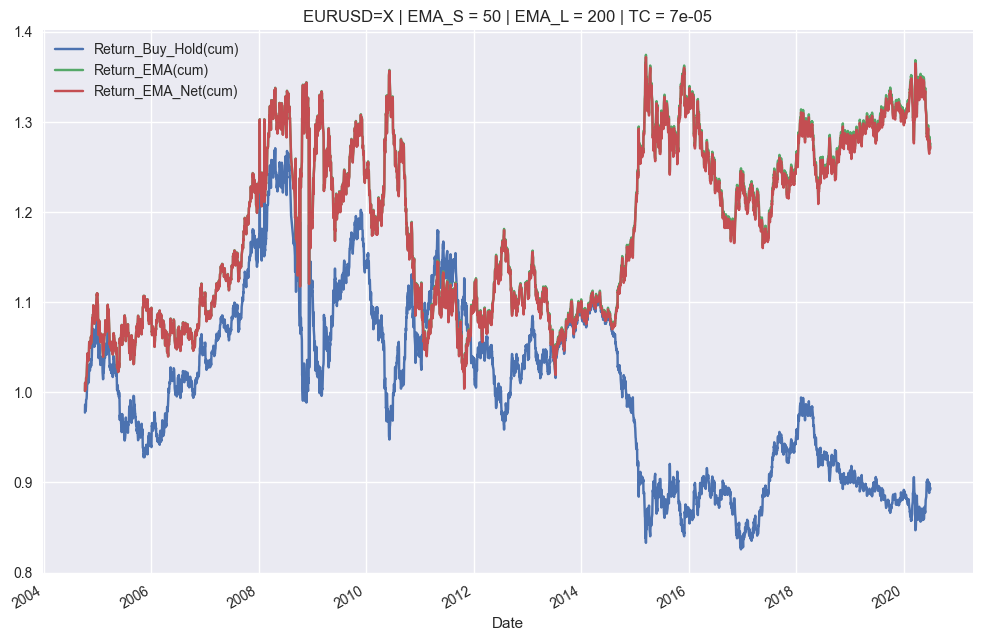

In [13]:
ema.plot_result()

In [14]:
ema.optimize_params(ema_s_range=EMA_S_RANGE, ema_l_range=EMA_L_RANGE)

array([ 36., 168.])